AuxTel Test LTS-337-032 (Auxiliary Telescope Shutter Closing Time)

Specification: The contractor shall, at a minimum, maintain the dome’s ability 
to close the shutters in a maximum of Aux_Tel_Dome_shutter_close_time. 

| Description | Value       | Unit          |   Name     |
| :---        |    :----:   |       :----:  |       ---: |
|The provided dome shall be able to close its shutter doors and vents in: | 300       | sec   |Aux_Tel_Dome_shutter_close_time|

To demonstrate the above dome capability, this notebook will calculate how long it took 
the dome main and dropout shutter to close at the end of an observing night, 
during the system `shutdown` procedure. 

An instance where the dome main and dropout shutters were both opened during the 2022 
February Run was found. The time ellapsed between the `closeShutter` command was 
received by the ATDome and the shutters completed closing is plotted and measured. 
The results and conclusion will be displayed in the notebook. 

This notebook is divided into 3 sections:
1. Notebook Setup
2. Analysis February Run - Main Door and Dropout Door Shutters Closing
3. Conclusions

# Notebook Setup. 

In [1]:
import sys, time, os, asyncio

from astropy.time import Time, TimeDelta
from lsst_efd_client import EfdClient

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Get EFD client
client = EfdClient('summit_efd')

# Analysis February Run - Main Door and Dropout Door Shutters Closing


*** 
On February 17th both main and dropout doors were open during the night. At the end 
of the night, as part of the shutdown procedure, both shutters were closed. 

In [3]:
# Get time when closeShutter command was received by ATDome. 
# An initial time interval was obtained from Chronograph. 
# Start and End Times from Chronograph. 
start_time = Time('2022-02-17T09:10:08.000', scale = 'utc')

end_time = Time('2022-02-17T09:20:00.000', scale = 'utc')



In [4]:
# Get time series command_closeShutter between start_time 
# and end_time. 
command_closeShutter = await client.select_time_series(
    "lsst.sal.ATDome.command_closeShutter",
    'private_efdStamp', 
    start_time, end_time)

In [5]:
# Get the time at which the command closeShutter command
# was received. 
time_command_received = Time(command_closeShutter.index[0])

# Calculate new time intervals around the above 
# time_command_received, starting 30 seconds before 
# and ending 350 seconds after. 
start_time = time_command_received + TimeDelta(
    -30, format ='sec')
end_time = time_command_received + TimeDelta(
    350, format='sec')

In [6]:
# Get time series for the main door and dropout door opening
# percentages between the new start and end times defined 
# above. 

mainDoor = await client.select_time_series(
    "lsst.sal.ATDome.position", 
    'mainDoorOpeningPercentage', 
    start_time, end_time)

dropoutDoor = await client.select_time_series(
    "lsst.sal.ATDome.position", 
    'dropoutDoorOpeningPercentage', 
    start_time, end_time)

In [7]:
# Convert the values into an array
percentageMainDoor = np.array(mainDoor.values.tolist())[:,0]
percentageDropoutDoor = np.array(dropoutDoor.values.tolist())[:,0]
# Substract all times from the time closeShutter command 
# was received. This means 0 seconds is when the command was 
# received. 
times=(mainDoor.index - command_closeShutter.index[0]).total_seconds()


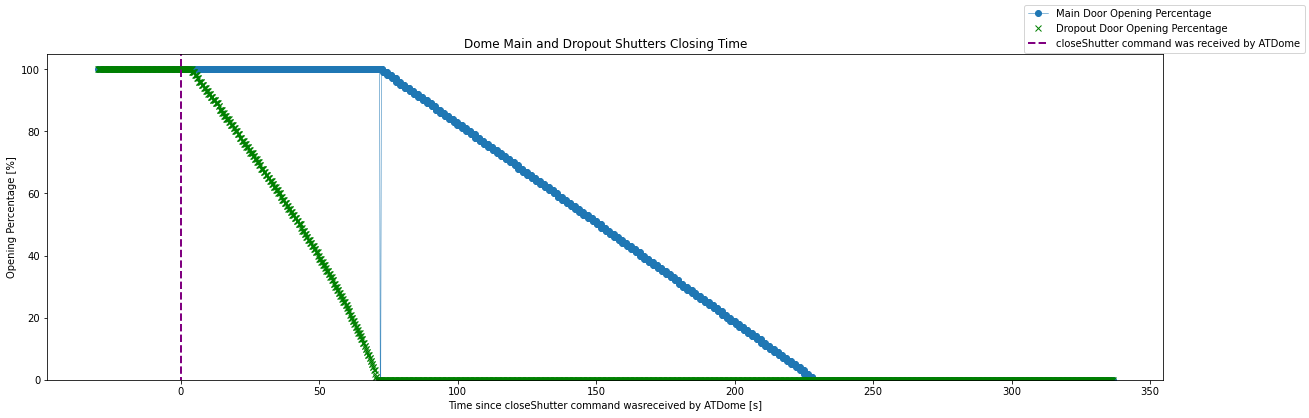

In [9]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(times, percentageMainDoor, 'C0o-', 
        label='Main Door Opening Percentage', lw=0.5)
ax.set_xlabel('Time since closeShutter command was' 
              'received by ATDome [s]')
ax.set_ylabel('Opening Percentage [%]')
ax.set_ylim(0,105)
ax.set_title(f'Dome Main and Dropout Shutters Closing Time')

ax.plot(times, percentageDropoutDoor, 'x', color = 'green',
                label='Dropout Door Opening Percentage', lw=0.5)
plt.vlines(x=[0], ymin = -5, ymax=[110], 
           color='purple', linestyles='--', lw=2, 
           label='closeShutter command was received by ATDome')
fig.legend()
plt.show()

In [10]:
Aux_Tel_Dome_shutter_close_time_MainDoor = times[(np.where(percentageMainDoor==0))[0][2]]
Aux_Tel_Dome_shutter_close_time_DropoutDoor = times[(np.where(percentageDropoutDoor==0))[0][2]]

In [11]:
Aux_Tel_Dome_shutter_close_time = max(
    Aux_Tel_Dome_shutter_close_time_MainDoor, 
    Aux_Tel_Dome_shutter_close_time_DropoutDoor)
print(f'The provided dome is able to close its both shutter'
      f' doors in {Aux_Tel_Dome_shutter_close_time:0.2f} seconds')

The provided dome is able to close its both shutter doors in 228.18 seconds


****

# Conclusion

*** 

The Auxiliary Telescope dome shutters closing time has been inspected from EFD data 
at the end-of-night system shutdown of the observing run on February 2022 run. 
(16, 17 and 18th February). On february 17th, both main and dropout shutters were opened and
its closing time was calculated. 

Examining the doors opening percentage telemetry, it's concluded that the provided 
dome was able to close its doors in 228.2 seconds, meeting the minimum 300 seconds 
specification requirement from LTS-337-032. 
